# 異常検知PoC
このNotebookでは、モータ電流データを用いて異常検知を行います。
手順は以下の通りです。
1. データの読み込み・前処理
2. 学習
3. 評価
4. 可視化と考察


## 1. データの読み込み・前処理

### ・JSONファイル作成をします。

In [1]:
# JSONファイル作成（正常・異常データ対応, 各windowごとのサイズを反映）

import os
import json
from pathlib import Path
import numpy as np
import pandas as pd

# ===== 設定 =====
col_index_cycle = 5    # サイクル列（0〜36000000を繰り返す列, 0始まり）
skip_header_rows = 31  # データ開始行
input_json = "file_settings_normal_abnormal_multiple_file_2.json"  # 元のファイル設定
output_json = "file_settings_customize.json"  # 作成するJSONファイル

# ===== CSV 読込関数 =====
def load_csv_data(path, col_index, start_row=0, end_row=None, skip_header_rows=31):
    if not os.path.exists(path):
        print(f"[警告] ファイルが見つかりません: {path}")
        return np.array([])
    try:
        df = pd.read_csv(
            path,
            header=None,
            encoding='cp932',
            sep=None,
            engine='python',
            skiprows=skip_header_rows
        )
    except UnicodeDecodeError:
        df = pd.read_csv(
            path,
            header=None,
            encoding='utf-8',
            sep=None,
            engine='python',
            skiprows=skip_header_rows
        )
    if col_index >= df.shape[1]:
        print(f"[警告] 列数不足: {path}")
        return np.array([])
    if end_row is None:
        data = df.iloc[start_row:, col_index]
    else:
        data = df.iloc[start_row:end_row, col_index]
    return data.to_numpy()

# ===== サイクル列からウィンドウ検出 =====
def detect_windows(cycle_values):
    start_rows = [0]
    for i in range(1, len(cycle_values)):
        if cycle_values[i] < cycle_values[i-1]:
            start_rows.append(i)
    windows = []
    for i in range(len(start_rows)):
        start = start_rows[i]
        end = start_rows[i+1] if i+1 < len(start_rows) else len(cycle_values)
        size = end - start
        windows.append((start, end, size))
    return windows

def filter_windows(windows):
    if not windows:
        return []
    sizes = [w[2] for w in windows]
    avg_size = np.mean(sizes)
    min_size = avg_size * 0.8
    return [w for w in windows if w[2] >= min_size]

# ===== 元JSON読み込み =====
with open(input_json, encoding="utf-8") as f:
    file_settings = json.load(f)

# ===== 新しいJSON作成 =====
custom_settings = {"normal": {}, "abnormal": {}}

# ----- 正常データ ----- #
for path in file_settings.get("normal", {}).keys():
    cycle_data = load_csv_data(path, col_index_cycle, skip_header_rows=skip_header_rows)
    if len(cycle_data) == 0:
        continue
    windows = detect_windows(cycle_data)
    filtered = filter_windows(windows)
    if not filtered:
        continue
    for idx, (start, end, size) in enumerate(filtered):
        key = f"{Path(path).as_posix()}_win{idx}"
        custom_settings["normal"][key] = {
            "original_path": path,
            "start_row": start,
            "end_row": end,
            "window_size": size   # ← 各windowの本来のサイズをそのまま出力
        }

# ----- 異常データ ----- #
for path in file_settings.get("abnormal", {}).keys():
    cycle_data = load_csv_data(path, col_index_cycle, skip_header_rows=skip_header_rows)
    if len(cycle_data) == 0:
        continue
    windows = detect_windows(cycle_data)
    filtered = filter_windows(windows)
    if not filtered:
        continue
    for idx, (start, end, size) in enumerate(filtered):
        key = f"{Path(path).as_posix()}_win{idx}"
        custom_settings["abnormal"][key] = {
            "original_path": path,
            "start_row": start,
            "end_row": end,
            "window_size": size   # ← 平均ではなく各区間のサイズを保存
        }

# ===== JSON書き出し =====
with open(output_json, "w", encoding="utf-8") as f:
    json.dump(custom_settings, f, ensure_ascii=False, indent=2)

print(f"[INFO] JSON作成完了 → {output_json}")


[INFO] JSON作成完了 → file_settings_customize.json


### ・特徴量作成し、CSVとして保存します。

In [2]:
# 特徴量作成 + CSV保存

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import json
import os

# ===== 設定 =====
col_index_current = 4   # 電流値（5列目）
col_index_speed   = 2   # モータ速度（3列目）
col_index_label   = 6   # ラベル列（7列目: 0=正常, 1=異常）
skip_header_rows  = 0
input_json        = "file_settings_customize.json"  # JSON作成済みファイル
anomaly_ratio_threshold = 0.5

# ===== CSV読込関数 =====
def load_csv_data(path, col_index, start_row=0, end_row=None, skip_header_rows=31):
    if not os.path.exists(path):
        print(f"[警告] ファイルが見つかりません: {path}")
        return np.array([])
    try:
        df = pd.read_csv(path, header=None, encoding='cp932', sep=None,
                         engine='python', skiprows=skip_header_rows)
    except UnicodeDecodeError:
        df = pd.read_csv(path, header=None, encoding='utf-8', sep=None,
                         engine='python', skiprows=skip_header_rows)

    if isinstance(col_index, list):
        data = df.iloc[start_row:end_row, col_index] if end_row else df.iloc[start_row:, col_index]
    else:
        data = df.iloc[start_row:end_row, col_index] if end_row else df.iloc[start_row:, col_index]
    return data.to_numpy()

# ===== 特徴量抽出関数 =====
def extract_features(current_data, speed_data, window_size):
    feats = []
    for i in range(0, len(current_data), window_size):
        cur_win = current_data[i:i+window_size]
        spd_win = speed_data[i:i+window_size]
        if len(cur_win) == window_size and len(spd_win) == window_size:
            ratio = cur_win / np.where(spd_win == 0, 1, spd_win)  # ゼロ割防止
            feats.append({
                # 電流特徴量
                "current_mean": np.mean(cur_win),
                "current_std": np.std(cur_win),
                "current_min": np.min(cur_win),
                "current_max": np.max(cur_win),
                # 速度特徴量
                "speed_mean": np.mean(spd_win),
                "speed_std": np.std(spd_win),
                "speed_min": np.min(spd_win),
                "speed_max": np.max(spd_win),
                # 電流/速度比
                "cur_spd_ratio_mean": np.mean(ratio),
                "cur_spd_ratio_std": np.std(ratio),
                "cur_spd_ratio_min": np.min(ratio),
                "cur_spd_ratio_max": np.max(ratio),
            })
    return pd.DataFrame(feats)

# ===== JSON読込 =====
with open(input_json, encoding="utf-8") as f:
    file_settings = json.load(f)

# ===== 正常データ（学習用） =====
train_features, train_labels = [], []

for key, setting in file_settings.get("normal", {}).items():
    path = setting["original_path"]
    start_row = setting["start_row"]
    end_row = setting["end_row"]
    window_size = setting["window_size"]

    current = load_csv_data(path, col_index_current, start_row, end_row)
    speed   = load_csv_data(path, col_index_speed, start_row, end_row)
    if len(current) == 0 or len(speed) == 0:
        continue

    feats = extract_features(current, speed, window_size)
    feats["source_file"] = Path(path).stem
    train_features.append(feats)
    train_labels.extend([1] * len(feats))  # 正常=1

train_df = pd.concat(train_features, ignore_index=True)

# ===== 異常データ（評価用） =====
eval_features, eval_labels = [], []

for key, setting in file_settings.get("abnormal", {}).items():
    path = setting["original_path"]
    start_row = setting["start_row"]
    end_row = setting["end_row"]
    window_size = setting["window_size"]

    data = load_csv_data(path, [col_index_current, col_index_speed, col_index_label], start_row, end_row)
    if len(data) == 0:
        continue
    current, speed, labels_csv = data[:,0], data[:,1], data[:,2]

    feats = extract_features(current, speed, window_size)
    feats["source_file"] = Path(path).stem
    eval_features.append(feats)

    # 多数決ラベル
    for i in range(0, len(labels_csv), window_size):
        window_labels = labels_csv[i:i+window_size]
        if len(window_labels) == window_size:
            abnormal_ratio = np.mean(window_labels == 1)
            eval_labels.append(-1 if abnormal_ratio > anomaly_ratio_threshold else 1)

eval_df = pd.concat(eval_features, ignore_index=True)
eval_df["label"] = eval_labels

# ===== CSV保存 =====
train_df.to_csv("train_features.csv", index=False, encoding="utf-8-sig")
eval_df.to_csv("eval_features.csv", index=False, encoding="utf-8-sig")

print("[INFO] train_features.csv / eval_features.csv を保存しました")
print("[INFO] train_features.csv の列:", train_df.columns.tolist())
print("[INFO] eval_features.csv の列:", eval_df.columns.tolist())


[INFO] train_features.csv / eval_features.csv を保存しました
[INFO] train_features.csv の列: ['current_mean', 'current_std', 'current_min', 'current_max', 'speed_mean', 'speed_std', 'speed_min', 'speed_max', 'cur_spd_ratio_mean', 'cur_spd_ratio_std', 'cur_spd_ratio_min', 'cur_spd_ratio_max', 'source_file']
[INFO] eval_features.csv の列: ['current_mean', 'current_std', 'current_min', 'current_max', 'speed_mean', 'speed_std', 'speed_min', 'speed_max', 'cur_spd_ratio_mean', 'cur_spd_ratio_std', 'cur_spd_ratio_min', 'cur_spd_ratio_max', 'source_file', 'label']


### ・特徴量の正規化と標準化を行います。

 ※ この工程は情報漏洩違反を考慮し、違反にあたらないよう正規化処理したデータに加工するためのものです。
    この工程がなくても結果が変わらないことを確認済みです。

In [4]:
# ===== 特徴量正規化スクリプト =====
import pandas as pd
from sklearn.preprocessing import StandardScaler

# ===== CSVパス =====
train_csv = "train_features.csv"
eval_csv  = "eval_features.csv"

# ===== 読み込み =====
train_df = pd.read_csv(train_csv)
eval_df  = pd.read_csv(eval_csv)

# ===== 特徴量列の自動抽出 =====
feature_cols = [col for col in train_df.columns if col not in ["source_file","label"]]
print(f"[INFO] 正規化対象の特徴量列: {feature_cols}")

# ===== 標準化 =====
scaler = StandardScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
eval_df[feature_cols]  = scaler.transform(eval_df[feature_cols])

# ===== 保存 =====
train_df.to_csv("train_features_scaled.csv", index=False, encoding="utf-8-sig")
eval_df.to_csv("eval_features_scaled.csv", index=False, encoding="utf-8-sig")

print("[INFO] 正規化後のCSVを保存しました")
print("  - train_features_scaled.csv")
print("  - eval_features_scaled.csv")


[INFO] 正規化対象の特徴量列: ['current_mean', 'current_std', 'current_min', 'current_max', 'speed_mean', 'speed_std', 'speed_min', 'speed_max', 'cur_spd_ratio_mean', 'cur_spd_ratio_std', 'cur_spd_ratio_min', 'cur_spd_ratio_max']
[INFO] 正規化後のCSVを保存しました
  - train_features_scaled.csv
  - eval_features_scaled.csv


## 2. 学習

### ・Isolation Forestの学習になります。

In [6]:
# isolation forest
# train_if.py
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import joblib  # モデル保存用

# ===== 設定 =====
train_features_csv = "train_features_scaled.csv"
feature_cols = None
model_save_path = "isolation_forest_model.pkl"
scaler_save_path = "scaler_if.pkl"

# ===== データ読み込み =====
train_df = pd.read_csv(train_features_csv)
feature_cols = [col for col in train_df.columns if col not in ["source_file","label"]]

# ===== 標準化 =====
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[feature_cols])

# ===== Isolation Forest 学習 =====
model_if = IsolationForest(contamination=0.3, random_state=42)
model_if.fit(X_train)

# ===== 保存 =====
joblib.dump(model_if, model_save_path)
joblib.dump(scaler, scaler_save_path)

print(f"[INFO] モデルとスケーラーを保存しました → {model_save_path}, {scaler_save_path}")


[INFO] モデルとスケーラーを保存しました → isolation_forest_model.pkl, scaler_if.pkl


### ・ One Class SVMの学習をします。

In [7]:
# One-Class SVM
# train_if.py

import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
import joblib

# ===== 設定 =====
train_features_csv = "train_features_scaled.csv"
feature_cols = None
model_save_path = "oneclass_svm_model.pkl"
scaler_save_path = "scaler_ocsvm.pkl"

# ハイパーパラメータ
nu_value = 0.0091
kernel_type = "rbf"
gamma_type = "scale"

# ===== データ読み込み =====
train_df = pd.read_csv(train_features_csv)
feature_cols = [c for c in train_df.columns if c not in ["source_file", "label"]]

# ===== 標準化 =====
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_df[feature_cols])

# ===== One-Class SVM 学習 =====
model_ocsvm = OneClassSVM(kernel=kernel_type, gamma=gamma_type, nu=nu_value)
model_ocsvm.fit(X_train_scaled)

# ===== 保存 =====
joblib.dump(model_ocsvm, model_save_path)
joblib.dump(scaler, scaler_save_path)

print(f"[INFO] One-Class SVM モデルとスケーラーを保存しました → {model_save_path}, {scaler_save_path}")


[INFO] One-Class SVM モデルとスケーラーを保存しました → oneclass_svm_model.pkl, scaler_ocsvm.pkl


### ・ Autoencoderの学習をします。

In [8]:
# Autoencoder
# train_if.py

import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import joblib

# ===== 設定 =====
train_features_csv = "train_features_scaled.csv"
feature_cols = ["current_mean","current_std","current_min","current_max",
                "speed_mean","speed_std","speed_min","speed_max",
                "cur_spd_ratio_mean","cur_spd_ratio_std","cur_spd_ratio_min","cur_spd_ratio_max"]

batch_size = 64
num_epochs = 40
learning_rate = 1e-3

model_save_path = "autoencoder_model.pth"
scaler_save_path = "scaler_ae.pkl"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] 使用デバイス: {device}")

# ===== データ読み込み =====
train_df = pd.read_csv(train_features_csv)

# ===== 標準化 =====
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
joblib.dump(scaler, scaler_save_path)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=batch_size, shuffle=True)

# ===== Autoencoder モデル =====
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4)
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

input_dim = X_train_scaled.shape[1]
model = Autoencoder(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# ===== 学習 =====
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        x_batch = batch[0]
        optimizer.zero_grad()
        x_hat = model(x_batch)
        loss = criterion(x_hat, x_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * x_batch.size(0)
    epoch_loss /= len(train_loader.dataset)
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"[INFO] Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}")

# ===== モデル保存 =====
torch.save(model.state_dict(), model_save_path)
print(f"[INFO] Autoencoder モデル保存 → {model_save_path}")
print(f"[INFO] 標準化スケーラー保存 → {scaler_save_path}")


[INFO] 使用デバイス: cpu
[INFO] Epoch 1/40, Loss: 1.018761
[INFO] Epoch 10/40, Loss: 0.198346
[INFO] Epoch 20/40, Loss: 0.079989
[INFO] Epoch 30/40, Loss: 0.026772
[INFO] Epoch 40/40, Loss: 0.018423
[INFO] Autoencoder モデル保存 → autoencoder_model.pth
[INFO] 標準化スケーラー保存 → scaler_ae.pkl


## 4. 評価

### ・ Isolation Forestの評価です。

[INFO] 評価結果
{'Accuracy': 0.9878542510121457, 'Precision': 0.9411764705882353, 'Recall': 0.9922480620155039, 'F1': 0.9660377358490566}

Confusion Matrix:
[[604   8]
 [  1 128]]


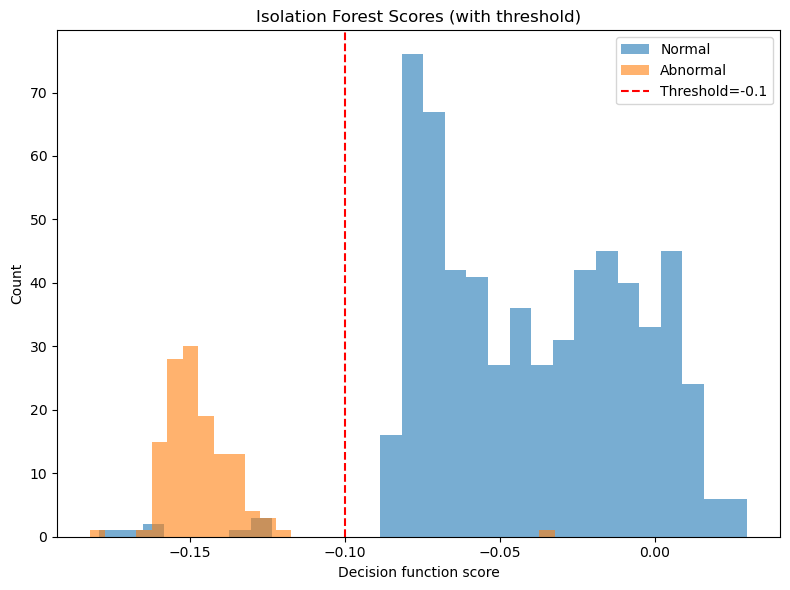

In [9]:
# isolation forest
# eval_if.py
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import joblib

# ===== 設定 =====
eval_features_csv = "eval_features_scaled.csv"
threshold_if = -0.1  # Isolation Forest 判定の閾値
model_save_path = "isolation_forest_model.pkl"
scaler_save_path = "scaler_if.pkl"

# ===== データ読み込み =====
eval_df = pd.read_csv(eval_features_csv)
feature_cols = [col for col in eval_df.columns if col not in ["source_file","label"]]
y_eval = eval_df["label"].astype(int).to_numpy()

# ===== 学習済みモデルとスケーラー読み込み =====
model_if = joblib.load(model_save_path)
scaler = joblib.load(scaler_save_path)

# ===== 標準化 =====
X_eval = scaler.transform(eval_df[feature_cols])

# ===== 予測 =====
scores_if = model_if.decision_function(X_eval)
preds_if = [1 if s >= threshold_if else -1 for s in scores_if]

# ===== 評価 =====
metrics = {
    "Accuracy": accuracy_score(y_eval, preds_if),
    "Precision": precision_score(y_eval, preds_if, pos_label=-1, zero_division=0),
    "Recall": recall_score(y_eval, preds_if, pos_label=-1, zero_division=0),
    "F1": f1_score(y_eval, preds_if, pos_label=-1, zero_division=0)
}
print("[INFO] 評価結果")
print(metrics)

# ===== 混同行列 & レポート =====
cm = confusion_matrix(y_eval, preds_if, labels=[1,-1])
print("\nConfusion Matrix:")
print(cm)
#print("\nClassification Report:")
#print(classification_report(y_eval, preds_if, labels=[1,-1], target_names=["Normal(1)","Anomaly(-1)"]))

# ===== ヒストグラム可視化 =====
plt.figure(figsize=(8,6))
plt.hist(scores_if[y_eval==1], bins=30, alpha=0.6, label="Normal")
plt.hist(scores_if[y_eval==-1], bins=30, alpha=0.6, label="Abnormal")
plt.axvline(threshold_if, color="red", linestyle="--", label=f"Threshold={threshold_if}")
plt.title("Isolation Forest Scores (with threshold)")
plt.xlabel("Decision function score")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig("isolation_forest_scores.png")
#print("[INFO] グラフ保存 → isolation_forest_scores.png")


### ・ One Class SVMの評価です。

[INFO] One-Class SVM 評価結果
{'Accuracy': 0.9932523616734144, 'Precision': 0.9696969696969697, 'Recall': 0.9922480620155039, 'F1': 0.9808429118773947}

Confusion Matrix:
[[608   4]
 [  1 128]]
[INFO] グラフ保存 → oneclass_svm_scores.png
[INFO] 評価結果保存 → oneclass_svm_results.csv


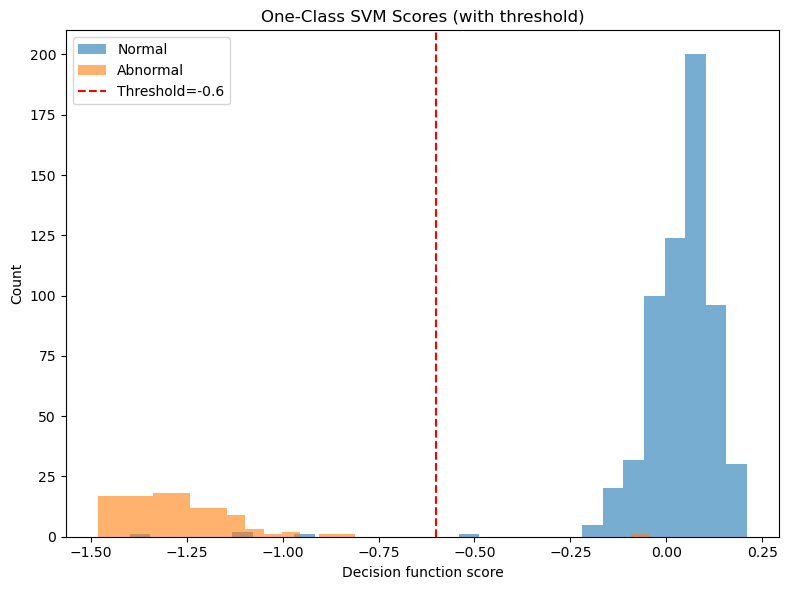

In [10]:
# One-Class SVM
# eval_if.py

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import joblib

# ===== 設定 =====
eval_features_csv = "eval_features_scaled.csv"
threshold_ocsvm = -0.6  # decision_function 閾値
model_save_path = "oneclass_svm_model.pkl"
scaler_save_path = "scaler_ocsvm.pkl"

# ===== データ読み込み =====
eval_df = pd.read_csv(eval_features_csv)
feature_cols = [c for c in eval_df.columns if c not in ["source_file", "label"]]
y_eval = eval_df["label"].astype(int).to_numpy()  # 1=正常, -1=異常

# ===== 学習済みモデル・スケーラー読み込み =====
model_ocsvm = joblib.load(model_save_path)
scaler = joblib.load(scaler_save_path)

# ===== 標準化 =====
X_eval_scaled = scaler.transform(eval_df[feature_cols])

# ===== 予測 =====
scores = model_ocsvm.decision_function(X_eval_scaled)
preds = np.where(scores >= threshold_ocsvm, 1, -1)

# ===== 評価 =====
metrics = {
    "Accuracy": accuracy_score(y_eval, preds),
    "Precision": precision_score(y_eval, preds, pos_label=-1, zero_division=0),
    "Recall": recall_score(y_eval, preds, pos_label=-1, zero_division=0),
    "F1": f1_score(y_eval, preds, pos_label=-1, zero_division=0)
}

print("[INFO] One-Class SVM 評価結果")
print(metrics)

# ===== 混同行列と分類レポート =====
cm = confusion_matrix(y_eval, preds, labels=[1, -1])
print("\nConfusion Matrix:")
print(cm)
#print("\nClassification Report:")
#print(classification_report(y_eval, preds, labels=[1, -1], target_names=["Normal(1)", "Anomaly(-1)"]))

# ===== スコア分布可視化 =====
plt.figure(figsize=(8,6))
plt.hist(scores[y_eval==1], bins=30, alpha=0.6, label="Normal")
plt.hist(scores[y_eval==-1], bins=30, alpha=0.6, label="Abnormal")
plt.axvline(threshold_ocsvm, color="red", linestyle="--", label=f"Threshold={threshold_ocsvm}")
plt.title("One-Class SVM Scores (with threshold)")
plt.xlabel("Decision function score")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig("oneclass_svm_scores.png")
print("[INFO] グラフ保存 → oneclass_svm_scores.png")

# ===== メトリクス保存 =====
pd.DataFrame([metrics]).to_csv("oneclass_svm_results.csv", index=False)
print("[INFO] 評価結果保存 → oneclass_svm_results.csv")


### ・ Autoencoderの評価です。

 ※ Autoencoderは学習をし直すたびにニューラルネットワークの重みの初期値がかわるため、
    結果に多少誤差が現れます。

[INFO] 使用デバイス: cpu
[INFO] Autoencoder 評価結果
{'Accuracy': 0.9892037786774629, 'Precision': 0.9481481481481482, 'Recall': 0.9922480620155039, 'F1': 0.9696969696969696}
[INFO] グラフ保存 → autoencoder_scores.png
[INFO] 評価結果保存 → autoencoder_results.csv


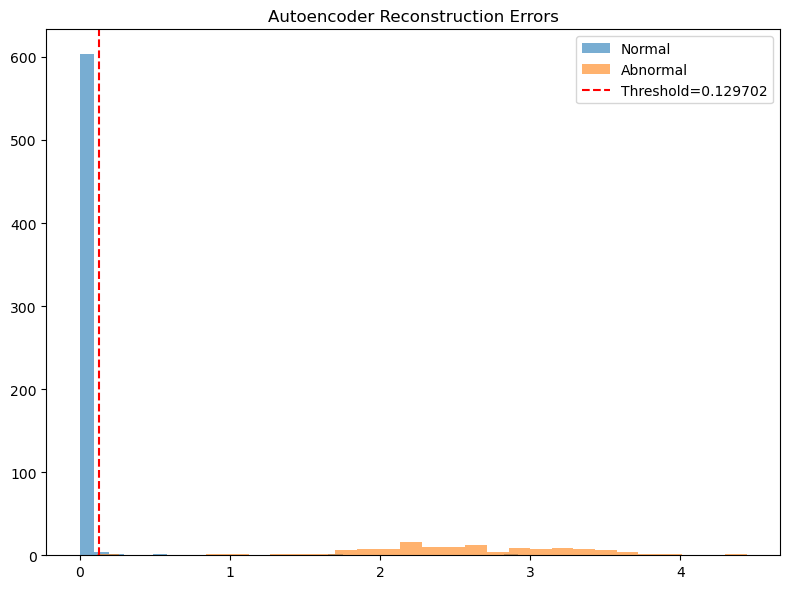

In [17]:
# Autoencoder
# eval_if.py

import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import joblib

# ===== 設定 =====
eval_features_csv = "eval_features_scaled.csv"
feature_cols = ["current_mean","current_std","current_min","current_max",
                "speed_mean","speed_std","speed_min","speed_max",
                "cur_spd_ratio_mean","cur_spd_ratio_std","cur_spd_ratio_min","cur_spd_ratio_max"]

model_save_path = "autoencoder_model.pth"
scaler_save_path = "scaler_ae.pkl"
threshold_quantile = 0.989  # 正常データのパーセンタイル

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] 使用デバイス: {device}")

# ===== データ読み込み =====
eval_df = pd.read_csv(eval_features_csv)
X_eval = eval_df[feature_cols].to_numpy()
y_eval = eval_df["label"].to_numpy()  # 1=正常, -1=異常

# ===== 学習済みスケーラー読み込み & 標準化 =====
scaler = joblib.load(scaler_save_path)
X_eval_scaled = scaler.transform(X_eval)
X_eval_tensor = torch.tensor(X_eval_scaled, dtype=torch.float32).to(device)

# ===== Autoencoder モデル定義 & 読み込み =====
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4)
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

input_dim = X_eval_scaled.shape[1]
model = Autoencoder(input_dim).to(device)
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.eval()

# ===== 異常スコア（再構築誤差）計算 =====
with torch.no_grad():
    recon_eval = model(X_eval_tensor)
    errors = torch.mean((X_eval_tensor - recon_eval) ** 2, dim=1).cpu().numpy()

# ===== 閾値設定（正常データのパーセンタイル） =====
threshold = np.quantile(errors[y_eval==1], threshold_quantile)
preds = np.where(errors > threshold, -1, 1)  # -1=異常, 1=正常

# ===== 評価 =====
metrics = {
    "Accuracy": accuracy_score(y_eval, preds),
    "Precision": precision_score(y_eval, preds, pos_label=-1, zero_division=0),
    "Recall": recall_score(y_eval, preds, pos_label=-1, zero_division=0),
    "F1": f1_score(y_eval, preds, pos_label=-1, zero_division=0)
}
print("[INFO] Autoencoder 評価結果")
print(metrics)

# ===== 可視化 =====
plt.figure(figsize=(8,6))
plt.hist(errors[y_eval==1], bins=30, alpha=0.6, label="Normal")
plt.hist(errors[y_eval==-1], bins=30, alpha=0.6, label="Abnormal")
plt.axvline(threshold, color="red", linestyle="--", label=f"Threshold={threshold:.6f}")
plt.title("Autoencoder Reconstruction Errors")
plt.legend()
plt.tight_layout()
plt.savefig("autoencoder_scores.png")
print("[INFO] グラフ保存 → autoencoder_scores.png")

# ===== メトリクス保存 =====
pd.DataFrame([metrics]).to_csv("autoencoder_results.csv", index=False)
print("[INFO] 評価結果保存 → autoencoder_results.csv")


In [19]:
import pandas as pd

# 保存した評価用特徴量を読み込み
eval_df  = pd.read_csv("eval_features.csv", encoding="utf-8-sig")

# ラベル件数をカウント
label_counts = eval_df["label"].value_counts().sort_index()

print("=== Evaluation Data Label Summary ===")
print(f"正常 (label=1)   : {label_counts.get(1, 0)} 件")
print(f"異常 (label=-1) : {label_counts.get(-1, 0)} 件")
print(f"合計             : {len(eval_df)} 件")


=== Evaluation Data Label Summary ===
正常 (label=1)   : 612 件
異常 (label=-1) : 129 件
合計             : 741 件


## 結果と考察

### 結果まとめ

#### Accuracy

  - Isolation Forest : 0.9878
  - One Class SVM    : 0.9932
  - Autoencoder      : 0.9892

#### Precision

  - Isolation Forest : 0.9411
  - One Class SVM    : 0.9696
  - Autoencoder      : 0.9481

#### Recall

  - Isolation Forest : 0.9922
  - One Class SVM    : 0.9922
  - Autoencoder      : 0.9922

#### F1 score
  - Isolation Forest : 0.9660
  - One Class SVM    : 0.9808
  - Autoencoder      : 0.9696
  
### 考察

- F1スコアは全モデルで高水準であったが、精度の差はわずかであった。
  - Isolation Forest は高速で大規模データに向いているため、リアルタイム監視用途に適する。
  - Autoencoder は非線形パターンの検出に強みがあるため、複雑な挙動の異常検知に有利。
  - One-Class SVM は少量データでも安定した検出が可能であり、小規模ライン向き。
  
- このことから、今回の用途（リアルタイム監視）では Isolation Forest が最も適していると考えられる。

- ただし、今回の実装では比較的高いスコアを出すことができましたが、データの件数が多いとは言えない量なので、過学習が起きている可能性があります。
  
### 展望

- 今後はデータセットを拡張し、モデルの汎化性能を検証。
- 特徴量の追加により、精度や汎化性能の向上を目指す。
- リアルタイム監視システムへの統合を検討。
